# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

#from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


Given the provided models, we are setting up the EMA workbench to evaluate them given uncertainties in model input parameters.

In [2]:
# introduce uncertainties to model parameters
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

# specify the model outputs
outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]

In [3]:
# initialize the different models we evaluate

# python model
pyton_model = Model('Python', function=PredPrey)
pyton_model.uncertainties = uncertainties
pyton_model.outcomes = outcomes

# excel model
excel_model = ExcelModel('Excel', wd='./model/', model_file='PredPrey.xlsx', default_sheet = 'Sheet1')
excel_model.uncertainties = uncertainties
excel_model.outcomes = outcomes

# vensim model
vensim_model = PysdModel('Vensim', mdl_file='./model/PredPrey.mdl')
vensim_model.uncertainties = uncertainties
vensim_model.outcomes = outcomes

In [4]:
# set up the ema workbench

# print updates on the model runs
ema_logging.log_to_stderr(ema_logging.INFO)

# define number of experiments for each model
nr_experiments = 50

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments([pyton_model, excel_model, vensim_model], nr_experiments)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 3 model(s) = 150 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] experiments finished


Now we have the output of the models, we get an idea of what the output looks like.

In [5]:
# get an idea of what the output looks like
for outcome, i in outcomes.items():
    print(outcome, i.shape)
    
print(experiments.shape)

TIME (150, 1, 1461)
predators (150, 1, 1461)
prey (150, 1, 1461)
(150, 7)


In [6]:
# get rid of the empty dimension in the outcomes matrix, since only one replication
# By default, each outcome array will then have a shape of (# experiments, # replications, # time steps)
for outcome, i in outcomes.items():
    outcomes[outcome] = np.squeeze(outcomes[outcome])

Visualizing the model output for the different models.

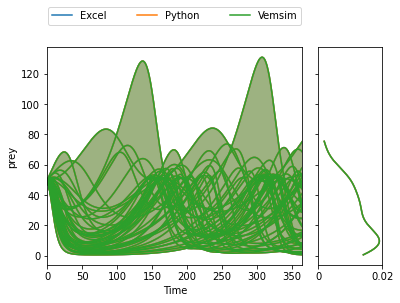

In [7]:
# plot the results using the 'lines' plotting from the ema workbench
experiments_indices = np.arange(0, experiments.shape[0], 1)

lines(experiments, outcomes, outcomes_to_show='prey', group_by='model',
      show_envelope=True, density=Density.KDE, titles=None, 
      experiments_to_show=experiments_indices)
plt.show()

We note that the results from the models seem to be the same, i.e. oevrlapping in the above graph. To check the graphical results, we find the maximum absolute error of the time series obtained for the prey variable in the excel and vensim models, relative to the Python function.

In [15]:
#Find the model implementations that were sampled in the experiments
model_types = [i for i in experiments.model.unique()]

boolean_python = experiments.model=='Python'

for model in model_types:
    if model != 'Python':
        boolean = experiments.model==model

        print('Max absolute error between python and %s model:' % model)
        print(np.max(abs(outcomes['prey'][boolean] - outcomes['prey'][boolean_python])))

Max absolute error between python and Excel model:
0.0
Max absolute error between python and Vemsim model:
1.5631940186722204e-13


Given there is no stochasticity in the models, we expect the maximum absolute difference to be zero. We can see that applies to the Excel comparison, however, in the case fo Vensim, there is a minuscule error. This might be attributed to the internal working of Vensim such as the integration step or the integration method.